In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from torchvision import datasets, models, transforms
import numpy as np
import os
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [64]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 10

In [66]:
baseDirectory = 'g:/Selim/Thesis/Code/PyTorch/'
setDirectory = 'Flower2Class'
setImageSize = 128

# EBA5 cropped mean and std values
#0.544978628454
#0.0564096715989
setMean = [0.544, 0.544, 0.544]
setStd = [0.056, 0.056, 0.056]

# EBA5 full mean and std
#Dim 0 mean: 0.558987606566
#Dim 0 stdv: 0.0675306702862
#setMean = [0.558, 0.558, 0.558]
#setStd = [0.067, 0.067, 0.067]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.RandomCrop(setImageSize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.RandomCrop(setImageSize),
        transforms.ToTensor(),
        #transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=10, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )
print(str(len(datasetClasses)) + ' output classes')

{'train': 1101, 'test': 430} images will be used.
GPU will be used.
2 output classes


(3, 128, 128)


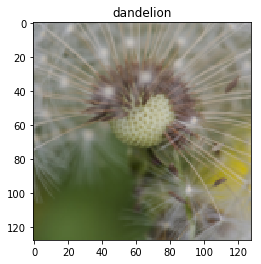

(3, 128, 128)


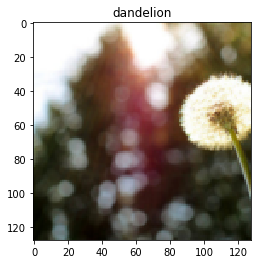

(3, 128, 128)


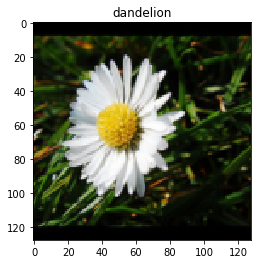

(3, 128, 128)


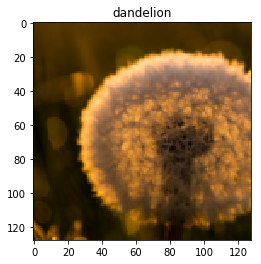

(3, 128, 128)


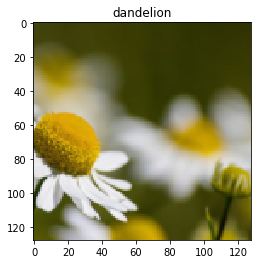

(3, 128, 128)


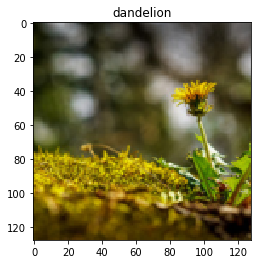

(3, 128, 128)


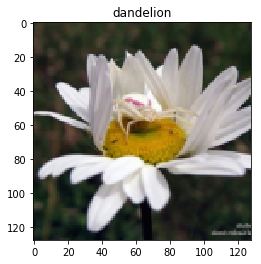

(3, 128, 128)


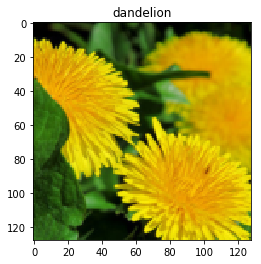

(3, 128, 128)


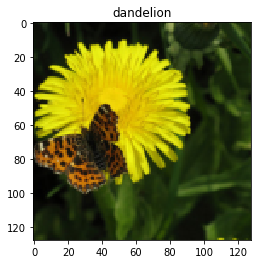

(3, 128, 128)


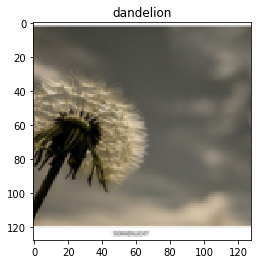

In [67]:
# plot one example
#print(datasetLoaders['train'].size())     # (60000, 28, 28)
#print(train_data.train_labels.size())   # (60000)

images, labels = next(iter(datasetLoaders['train']))
#images, labels = next(iter(datasetLoaders['train']))[0].numpy()

for i in range(images.size()[0]):
    image = images.numpy()[i]
    print(image.shape)
    plt.figure()
    plt.imshow(image.transpose((1, 2, 0)), cmap='gray')
    plt.title('%s' % datasetClasses[labels[0]])
    plt.show()

In [71]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3*128*128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 3*128*128),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [72]:
autoencoder = AutoEncoder().cuda()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss().cuda()

# original data (first row) for viewing
#view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = Variable(images.view(-1, 3*128*128).type(torch.FloatTensor)/255.).cuda()
print(view_data.data.cpu().numpy().shape)

AutoEncoder (
  (encoder): Sequential (
    (0): Linear (49152 -> 128)
    (1): Tanh ()
    (2): Linear (128 -> 64)
    (3): Tanh ()
    (4): Linear (64 -> 12)
    (5): Tanh ()
    (6): Linear (12 -> 3)
  )
  (decoder): Sequential (
    (0): Linear (3 -> 12)
    (1): Tanh ()
    (2): Linear (12 -> 64)
    (3): Tanh ()
    (4): Linear (64 -> 128)
    (5): Tanh ()
    (6): Linear (128 -> 49152)
    (7): Sigmoid ()
  )
)
(10, 49152)


Epoch:  0 | train loss: 0.0829
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)


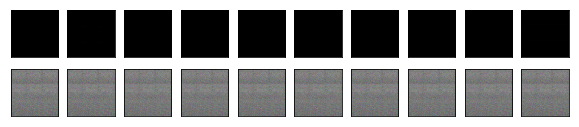

Epoch:  9 | train loss: 0.0758
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)


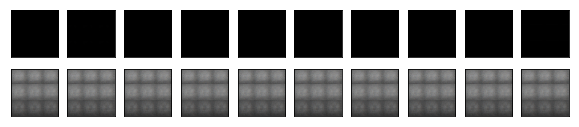

In [77]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(datasetLoaders['train']):
        b_x = Variable(x.view(-1, 3*128*128)).cuda()   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 3*128*128)).cuda()   # batch y, shape (batch, 28*28)
        b_label = Variable(y).cuda()               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 10, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(10, 2))
            
            for i in range(N_TEST_IMG):
                print(view_data.cpu().data.numpy()[i].shape)
                a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i], (128, 128, 3))); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i], (128, 128, 3)))
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)

In [55]:
# visualize in 3D plot
view_data = Variable(train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()

NameError: name 'train_data' is not defined